# Testing the accuracy of the new loookup table
## Conclusion: The residual unit norm is less than 1% across whole paameter space :)

In [1]:
#!/home/anuj.mishra/anaconda3/envs/gwpy/bin/python

import numpy as np

import sys
import mpmath
from mpmath import hyp1f1
import math
import scipy
from scipy.interpolate import interp1d
import pandas as pd

from copy import deepcopy

from itertools import product
from functools import partial
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import pickle

sys.path.append('../src/')
import pnt_lens_class 
pnt_lens_py = pnt_lens_class.point_lens()

# loading Cython version of the point lens class
import cythonized_pnt_lens_class as pnt_lens_cy
   
    

## 1. Loading lookup table and reconstructing the grid form the data

In [2]:
import pickle

outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0'

with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)

print('\nNumber of entries in lookup_table: ', len(Ff_grid)) 
Ff_grid[str(0)]


Number of entries in lookup_table:  35000


{'y': 0.01,
 'ws': array([1.00000000e-04, 1.00311921e-04, 1.00624816e-04, ...,
        1.29192783e+04, 1.29595763e+04, 1.30000000e+04]),
 'Ffs_real': array([ 1.00007841,  1.00007865,  1.0000789 , ..., 12.02985878,
        14.14185837, 11.91298484]),
 'Ffs_imag': array([-5.15356541e-04, -5.16807959e-04, -5.18263418e-04, ...,
        -5.01931555e+00,  7.88613724e-02,  5.14481310e+00])}

### 2. Relevant Functions

In [14]:
def y_w_grid_data(Ff_grid):
    ys_grid = np.array([Ff_grid[str(i)]['y'] for i in range(len(Ff_grid))])
    ws_grid = Ff_grid['0']['ws']
    return ys_grid, ws_grid

def y_index(yl, ys_grid):
    return np.argmin(np.abs(ys_grid - yl))

def w_index(w, ws_grid):
    return np.argmin(np.abs(ws_grid - w))

  


def pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid, extrapolate=True):
    wfs = np.array([pnt_lens_cy.w_of_f(f, Mlz) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(yl)

    wfs_1 = wfs[wfs <= np.min(ws_grid)]
    Ffs_1 = np.array([1]*len(wfs_1))

    wfs_2 = wfs[(wfs > np.min(ws_grid))&(wfs <= np.max(ws_grid))]
    wfs_2_wave = wfs_2[wfs_2 <= wc]
    wfs_2_geo = wfs_2[wfs_2 > wc]

    i_y  = y_index(yl, ys_grid)
    tmp_Ff_dict = Ff_grid[str(i_y)]
    ws = tmp_Ff_dict['ws']
    Ffs = tmp_Ff_dict['Ffs_real'] + 1j*tmp_Ff_dict['Ffs_imag']
    fill_val = ['interpolate', 'extrapolate'][extrapolate]
    i_Ff = interp1d(ws, Ffs, fill_value=fill_val)
    Ffs_2_wave = i_Ff(wfs_2_wave)

    Ffs_2_geo = np.array([pnt_lens_cy.point_Fw_geo(w, yl) for w in wfs_2_geo])

    wfs_3 = wfs[wfs > np.max(ws_grid) ]
    Ffs_3 = np.array([pnt_lens_cy.point_Fw_geo(w, Mlz) for w in wfs_3])

    Ffs = np.concatenate((Ffs_1, Ffs_2_wave, Ffs_2_geo, Ffs_3))
    assert len(Ffs)==len(fs), 'len(Ffs) = {} does not match len(fs) = {}'.format(len(Ffs), len(fs))
    return Ffs





In [18]:
ys_grid, ws_grid = y_w_grid_data(Ff_grid)
fs = np.arange(0, 1024, 1/4)
pnt_Ff_lookup_table([10], 1, 0.008, ys_grid, ws_grid)

array([1.00096104-0.00483024j])

### 3. Usage

In [85]:
ys_grid, ws_grid = y_w_grid_data(Ff_grid)

t1 = time.time()
Mlzs = np.logspace(1, 4, 50)
ys = np.logspace(-2, np.log10(5), 50)
fs = np.arange(0, 1024, 1/4)
input_prms = np.array(list(product(Mlzs, ys)))

def comp_residual(i):
    Mlz, yl = input_prms[i]
    Ffs_LT = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
    Ffs_A = np.array([pnt_lens_cy.point_Ff_eff(f, Mlz, yl) for f in fs])
    residual = np.linalg.norm( Ffs_A/np.linalg.norm(Ffs_A) - Ffs_LT/np.linalg.norm(Ffs_LT) )
    return residual

if __name__=='__main__':
    import multiprocessing as mp
    pool = mp.Pool(4)
    residuals = np.array(list(tqdm(pool.imap(comp_residual, np.arange(len(input_prms))), total=len(input_prms))))
    
t2 = time.time()
print((t2-t1)/len(input_prms))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:11<00:00, 18.94it/s]

0.05294016962051391


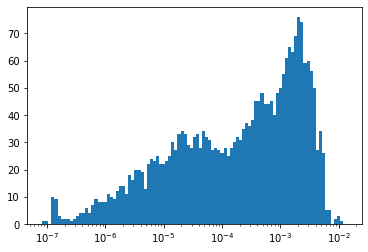

In [95]:
plt.hist(residuals, bins=np.logspace( np.log10(np.min(residuals)), np.log10(np.max(residuals)), 100 ))
plt.xscale('log')
plt.show()

### Focusing on higher ys

In [5]:
ys_grid, ws_grid = y_w_grid_data(Ff_grid)

t1 = time.time()
Mlzs = np.logspace(1, 4, 10)
ys = np.logspace(np.log10(1), np.log10(5), 200)
fs = np.arange(0, 1024, 1/4)
input_prms = np.array(list(product(Mlzs, ys)))

def comp_residual(i):
    Mlz, yl = input_prms[i]
    Ffs_LT = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
    Ffs_A = np.array([pnt_lens_cy.point_Ff_eff(f, Mlz, yl) for f in fs])
    residual = np.linalg.norm( Ffs_A/np.linalg.norm(Ffs_A) - Ffs_LT/np.linalg.norm(Ffs_LT) )
    return residual

if __name__=='__main__':
    import multiprocessing as mp
    pool = mp.Pool(4)
    residuals = np.array(list(tqdm(pool.imap(comp_residual, np.arange(len(input_prms))), total=len(input_prms))))
    
t2 = time.time()
print((t2-t1)/len(input_prms))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:15<00:00, 26.62it/s]

0.03774756872653961


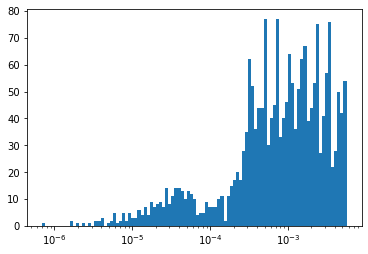

In [6]:
plt.hist(residuals, bins=np.logspace( np.log10(np.min(residuals)), np.log10(np.max(residuals)), 100 ))
plt.xscale('log')
plt.show()

### cross-checking with the original python class as well

In [1]:
ys_grid, ws_grid = y_w_grid_data(Ff_grid)

t1 = time.time()
Mlzs = np.logspace(1, 4, 15)
ys = np.logspace(-2, np.log10(5), 15)
fs = np.arange(0, 1024, 1/4)
input_prms = np.array(list(product(Mlzs, ys)))

def comp_residual(i):
    Mlz, yl = input_prms[i]
    Ffs_LT = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
    Ffs_A = np.array([pnt_lens_py.point_Ff_eff(f, Mlz, yl) for f in fs])
    residual = np.linalg.norm( Ffs_A/np.linalg.norm(Ffs_A) - Ffs_LT/np.linalg.norm(Ffs_LT) )
    return residual

if __name__=='__main__':
    import multiprocessing as mp
    pool = mp.Pool(4)
    residuals = np.array(list(tqdm(pool.imap(comp_residual, np.arange(len(input_prms))), total=len(input_prms))))
    
t2 = time.time()
print((t2-t1)/len(input_prms))

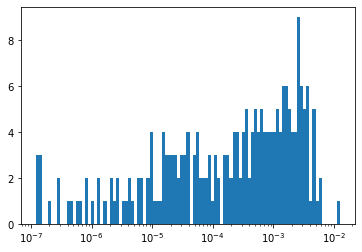

In [99]:
plt.hist(residuals, bins=np.logspace( np.log10(np.min(residuals)), np.log10(np.max(residuals)), 100 ))
plt.xscale('log')
plt.show()

## Source

In [ ]:
############################################# Custom Source Models for Bilby ######################################################
### I. Point Lens Parameter Estimation ###

import sys
sys.path.append('/home/anuj.mishra/git_repos/git_GWs/Ff_comp/cython/a1_pnt_lens_class/')  #path to the dir containing cython module
# loading Cython version of the point lens class
import cythonized_pnt_lens_class as pnt_lens_cy

## functions
def y_w_grid_data(Ff_grid):
    ys_grid = np.array([Ff_grid[str(i)]['y'] for i in range(len(Ff_grid))])
    ws_grid = Ff_grid['0']['ws']
    return ys_grid, ws_grid

def y_index(yl, ys_grid):
    return np.argmin(np.abs(ys_grid - yl))

def w_index(w, ws_grid):
    return np.argmin(np.abs(ws_grid - w))

def pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid, extrapolate=True):
    wfs = np.array([pnt_lens_cy.w_of_f(f, Mlz) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(yl)

    wfs_1 = wfs[wfs <= np.min(ws_grid)]
    Ffs_1 = np.array([1]*len(wfs_1))

    wfs_2 = wfs[(wfs > np.min(ws_grid))&(wfs <= np.max(ws_grid))]
    wfs_2_wave = wfs_2[wfs_2 <= wc]
    wfs_2_geo = wfs_2[wfs_2 > wc]

    i_y  = y_index(yl, ys_grid)
    tmp_Ff_dict = Ff_grid[str(i_y)]
    ws = tmp_Ff_dict['ws']
    Ffs = tmp_Ff_dict['Ffs_real'] + 1j*tmp_Ff_dict['Ffs_imag']
    fill_val = ['interpolate', 'extrapolate'][extrapolate]
    i_Ff = interp1d(ws, Ffs, fill_value=fill_val)
    Ffs_2_wave = i_Ff(wfs_2_wave)
    
    Ffs_2_geo = np.array([pnt_lens_cy.point_Fw_geo(w, yl) for w in wfs_2_geo])

    wfs_3 = wfs[wfs > np.max(ws_grid) ]
    Ffs_3 = np.array([pnt_lens_cy.point_Fw_geo(w, Mlz) for w in wfs_3])

    Ffs = np.concatenate((Ffs_1, Ffs_2_wave, Ffs_2_geo, Ffs_3))
    assert len(Ffs)==len(fs), 'len(Ffs) = {} does not match len(fs) = {}'.format(len(Ffs), len(fs))
    return Ffs     


print('## Loading and setting up the lookup table ##')
import pickle
lookup_table_file = '/home/anuj.mishra/misc_data/pnt_Ff_grid_data/lookup_table_generation/data/point_lens_Ff_lookup_table_Geo_relErr_1p0.pkl'

with open(lookup_table_file, 'rb') as f:
    Ff_grid = pickle.load(f)
    
ys_grid, ws_grid = y_w_grid_data(Ff_grid)    
print('## Done ##')


### S1. Source Model for point lens microlensing using lookup table ###
def point_lens_MiL_BBH(frequency_array, mass_1, mass_2, luminosity_distance, a_1, tilt_1,
                          phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, Log_Mlz, yl, **kwargs):

    waveform_kwargs = dict(
        waveform_approximant='IMRPhenomPv2', reference_frequency=50.0,
        minimum_frequency=20.0, maximum_frequency=frequency_array[-1],
        catch_waveform_errors=False, pn_spin_order=-1, pn_tidal_order=-1,
        pn_phase_order=-1, pn_amplitude_order=0)
    waveform_kwargs.update(kwargs)

    try:
        lal_res = lal_binary_black_hole(frequency_array, mass_1, mass_2, luminosity_distance, a_1, tilt_1,
                  phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, **kwargs)

        Mlz = np.power(10, Log_Mlz)
        if round(Mlz, 3) == 0:
            return dict(plus=lal_res['plus'], cross=lal_res['cross']) 
        else:
            Ff = pnt_Ff_lookup_table(fs=frequency_array, Mlz=Mlz, yl=yl, ys_grid=ys_grid, ws_grid=ws_grid)
            lhp = Ff*lal_res['plus']
            lhc = Ff*lal_res['cross']
            return dict(plus=lhp, cross=lhc)
    except Exception as e:
        print(e)
        pass


### S2. Source Model for point lens microlensing using Analytic func + Geo Optics approx. (more accurate but slower; not recommended for PE) ###
def point_lens_MiL_BBH_analytic(frequency_array, mass_1, mass_2, luminosity_distance, a_1, tilt_1,
                          phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, Log_Mlz, yl, **kwargs):

    waveform_kwargs = dict(
        waveform_approximant='IMRPhenomPv2', reference_frequency=50.0,
        minimum_frequency=20.0, maximum_frequency=frequency_array[-1],
        catch_waveform_errors=False, pn_spin_order=-1, pn_tidal_order=-1,
        pn_phase_order=-1, pn_amplitude_order=0)
    waveform_kwargs.update(kwargs)

    try:
        lal_res = lal_binary_black_hole(frequency_array, mass_1, mass_2, luminosity_distance, a_1, tilt_1,
                  phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, **kwargs)

        Mlz = np.power(10, Log_Mlz)	
        if round(Mlz, 3) == 0:
            return dict(plus=lal_res['plus'], cross=lal_res['cross'])
        else:
            Ff = np.array([pnt_lens_cy.point_Ff_eff(f, ml=Mlz, y=yl) for f in frequency_array])
            lhp = Ff*lal_res['plus']
            lhc = Ff*lal_res['cross']
            return dict(plus=lhp, cross=lhc)

    except Exception as e:
        pass

################################################  END of "Custom Models" ##########################################################